In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import glob
import re
from tkinter import filedialog as fd
from tkinter import *
from scipy.stats import lognorm
from matplotlib.colors import PowerNorm

In [2]:
def Gaussian(x, a, Mean, Sigma):
    return a * np.exp(-((x - Mean)**2 / (2 * Sigma**2)))

def LogNorm(x, a, Mu, Sigma):
    return a/(x*Sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-Mu)**2/(2.0*Sigma**2))

In [3]:
def readParticleConfig(path,ConfigurationNumber):
    TotalNumberOfParticles = int(re.search(r'(?<=N=)[\d]*',path).group())
    with open(path,'r') as F:
        Data = F.read()
    RowOffset = 1+ConfigurationNumber*(TotalNumberOfParticles+2)
    print("RowOffset: ",RowOffset)
    Data = Data.strip()
    FirstRow = Data.split(sep='\n')[RowOffset]
    NumberOfAParticles = int(FirstRow.split()[5].strip('|'))
    NumberOfBParticles = int(FirstRow.split()[7].strip('|'))
    ListOfRows = Data.split(sep='\n')[RowOffset+1:RowOffset+1+TotalNumberOfParticles]
    if (len(ListOfRows) > 0):
        NumberOfColumns = len(ListOfRows[0].split()) - 1
    else:
        NumberOfColumns = 0
    APositions = np.empty((NumberOfAParticles, NumberOfColumns))
    BPositions = np.empty((NumberOfBParticles, NumberOfColumns))
    AIndex = 0
    BIndex = 0
    
    for i in range(len(ListOfRows)):
        if (ListOfRows[i].split()[NumberOfColumns] == 'A'):
            for j in range(NumberOfColumns):
                APositions[AIndex,j] = ListOfRows[i].split()[j]
            AIndex += 1
        else:
            for j in range(NumberOfColumns):
                BPositions[BIndex,j] = ListOfRows[i].split()[j]
            BIndex += 1
    return APositions, BPositions

def getFilePathFromDialog(_initialdir):
    root = Tk()
    FilePath = fd.askopenfilename(initialdir = _initialdir)
    root.destroy()
    return FilePath

def getDirectoryPathFromDialog(_initialdir):
    root = Tk()
    Directory = fd.askdirectory(initialdir = _initialdir)
    root.destroy()
    return Directory

def readParticleConfigFromDialog(ConfigurationNumber):
    return readParticleConfig(getFilePathFromDialog(dataPath),ConfigurationNumber)

In [4]:
def readSeries(path):
    with open(path,'r') as F:
        Data = F.read()
    Data = Data.strip()
    ListOfData = Data.split(sep='\n')[1:]
    NumberOfEntries = len(ListOfData)
    Series = np.empty(NumberOfEntries)
    for i in range(NumberOfEntries):
        Series[i] = ListOfData[i]
    return Series

def readSeriesFromDialog():
    return readSeries(getFilePathFromDialog(dataPath))

def readInResults():
    Temperatures = []
    NASeries = []
    TotalNumberOfParticles = []
    DirectoryPath = getDirectoryPathFromDialog(dataPath)
    Density = float(re.search(r'(?<=Roh=)[\d]*.[\d]*',DirectoryPath).group())
    epsAB = float(re.search(r'(?<=epsAB=)[\d]*.[\d]*',DirectoryPath).group())
    for Directory in sorted(glob.glob(DirectoryPath+'/T=*')):
        FileName = glob.glob(Directory+'/NA_Series*')[0]
        NASeries.append(readSeries(FileName))
        Temperatures.append(float(re.search(r'(?<=T=)[\d]*\.[\d]*',FileName).group()))
        TotalNumberOfParticles.append(float(re.search(r'(?<=N=)[\d]*',FileName).group()))
    return Density, Temperatures, NASeries, TotalNumberOfParticles, epsAB

In [5]:
def computeEquilibriumAverage(Series):
    n = 0
    while (n < len(Series)):
        Average = np.mean(Series[n:])
        Deviations = np.abs(Average-Series[n:])
        AverageDeviation = np.mean(Deviations)
        if (np.abs(Average-Series[n]) < AverageDeviation):
            return Average,AverageDeviation,n
        n += 1
    return np.mean(Series[:]), np.mean(np.abs(np.mean(Series[:])-Series[:])), 0

In [6]:
def computeHist(Series):
    Min = int(np.min(Series))
    Max = int(np.max(Series))
    yValues = np.zeros(Max - Min + 1)
    xValues = np.arange(Min,Max + 1)
    for Entry in Series:
        yValues[int(Entry)-Min] += 1
    return yValues,xValues

In [7]:
def computeMomentOfDistribution(xValues,yValues,Exponent):
    h = xValues[1]-xValues[0]
    Moment = 0.5*(xValues[0]**Exponent*yValues[0]+xValues[-1]**Exponent*yValues[-1])
    for i in range(1,len(xValues)-1,1):
        Moment += xValues[i]**Exponent*yValues[i]
    return h*Moment

In [8]:
def computeNormalizedDistribution(NASeries, TotalNumberOfParticles):
    NumberOfAAverage, AverageNumberDeviation, NumberIndex = computeEquilibriumAverage(NASeries)
    yValues, xValues = computeHist(NASeries[NumberIndex:])
    xValues = xValues/TotalNumberOfParticles
    TotalIntegral = computeMomentOfDistribution(xValues,yValues,0.0)
    return xValues, yValues/TotalIntegral

In [9]:
def computeFirstMoments(NASeries,Temperatures,TotalNumberOfParticles):
    Fig, Ax = plt.subplots(len(NASeries),1,squeeze=False,figsize=(5,len(NASeries)*3))
    FirstMoments = []
    i = 0
    for OneSeries in NASeries:
        print("Computing first moment of T=",Temperatures[i],end='; ')
        xValues, yValues = computeNormalizedDistribution(OneSeries,TotalNumberOfParticles)
        FirstMoment = computeMomentOfDistribution(xValues,yValues,1.0)
        Ax[i,0].plot(xValues,yValues,label='T='+str(Temperatures[i]))
        Ax[i,0].legend()
        Ax[i,0].vlines(FirstMoment, min(yValues), max(yValues), color='k', alpha = 0.5)
        FirstMoments.append(FirstMoment)
        i+=1
        print(FirstMoment)
    return FirstMoments

In [10]:
def readFile(path):
    return np.loadtxt(path, dtype=float, skiprows = 1)

def readFileFromDialog():
    return readFile(getFilePathFromDialog(dataPath))

In [11]:
def plotMultipleProbDists():
    Directory = getDirectoryPathFromDialog(dataPath);
    AllProbDists = sorted(glob.glob(Directory+"/*ProbDist*"))
    NumberOfDiagrams = len(AllProbDists)
    Fig, Ax = plt.subplots(NumberOfDiagrams,1,squeeze=False, figsize=(5,5*NumberOfDiagrams))
    for i in range(NumberOfDiagrams):
        Temperature = float(re.search(r'(?<=_T=)[\d]*.[\d]*',AllProbDists[i]).group())
        xAProbDist = readFile(AllProbDists[i])
        Ax[i,0].plot(xAProbDist[:,0],xAProbDist[:,1])
        Ax[i,0].set_title("T="+str(Temperature))

In [12]:
def readMultiplePhaseBinderResults():
    Directory = getDirectoryPathFromDialog(dataPath);
    AllDirectories = glob.glob(Directory+"/*")
    NumberOfCurves = len(AllDirectories)
    NList = []
    PhaseBinderResultsList = []
    for i in range(NumberOfCurves):
        NList.append(float(re.search(r'(?<=N=)[\d]*',AllDirectories[i]).group()))
        PhaseBinderResultsList.append(readFile(glob.glob(AllDirectories[i]+"/analyzed_data/first*")[0]))
    return NList,PhaseBinderResultsList

In [13]:
def plotMultipleNAAndPotEnergySeries():
    Directory = getDirectoryPathFromDialog(dataPath);
    AllNASeries = glob.glob(Directory+"/NA*")
    NumberOfSeries = len(AllNASeries)
    Fig,Ax = plt.subplots(NumberOfSeries,4,squeeze=False, figsize=(17,5*NumberOfSeries))
    for i in range(NumberOfSeries):
        RunNumber = re.search(r'(?<=_)[\d]*(?=(.dat))',AllNASeries[i]).group()
        NASeries = readFile(AllNASeries[i])
        PotSeries = readFile(glob.glob(Directory+"/PotEnergy*_"+RunNumber+".dat")[0])
        PotEnergyAverage = np.mean(PotSeries)
        Ax[i,0].plot(NASeries,'.')
        Ax[i,0].set_title("Run "+RunNumber)
        yValues, xValues = computeHist(NASeries)
        Ax[i,1].plot(xValues,yValues)
        Ax[i,1].set_xlabel(r'$N_A$')
        Ax[i,1].set_ylabel('number of occurences')
        Ax[i,2].plot(PotSeries,'.')
        Ax[i,3].hist(PotSeries,bins = 20, density = True)
        Ax[i,3].vlines(PotEnergyAverage,0,0.004,color='g',label="PotEnergyAvg={}".format(round(PotEnergyAverage,2)))
        Ax[i,3].legend()
        print(RunNumber)

In [14]:
dataPath = getDirectoryPathFromDialog('')

In [ ]:
plotMultipleNAAndPotEnergySeries()

## Series of particle number

In [ ]:
NumberOfASeries = readSeriesFromDialog()

In [ ]:
Fig, Host = plt.subplots(1,1,squeeze=False, figsize = (12,5), dpi = 100)
Host[0,0].plot(NumberOfASeries,'.')

In [ ]:
Fig, Ax = plt.subplots(1,1,squeeze=False, figsize=(5,5))
yValues, xValues = computeHist(NumberOfASeries)
Ax[0,0].plot(xValues,yValues)
Ax[0,0].set_xlabel(r'$N_A$')
Ax[0,0].set_ylabel('number of occurences')

## Series of potential energy

In [ ]:
PotEnergySeries = readSeriesFromDialog()

In [ ]:
PotEnergyAverage, AverageEnergyDeviation, EnergyIndex = computeEquilibriumAverage(PotEnergySeries)
print(PotEnergyAverage, AverageEnergyDeviation, EnergyIndex)

In [ ]:
Fig, Host = plt.subplots(1,1,squeeze=False, figsize = (12,5), dpi = 100)
Host[0,0].plot(PotEnergySeries,'.')
Host[0,0].plot(np.ones(len(PotEnergySeries))*PotEnergyAverage,color='darkorange',label='Gleichgewichts-Mittel')
Host[0,0].plot(np.ones(len(PotEnergySeries))*PotEnergyAverage+AverageEnergyDeviation,color='darkorange',alpha= 0.5)
Host[0,0].plot(np.ones(len(PotEnergySeries))*PotEnergyAverage-AverageEnergyDeviation,color='darkorange',alpha = 0.5)
Host[0,0].vlines(EnergyIndex, min(PotEnergySeries), max(PotEnergySeries), color = 'k', alpha = 0.5)

In [ ]:
Fig, Ax = plt.subplots(1,1,squeeze=False, figsize=(5,5))
Ax[0,0].hist(PotEnergySeries[EnergyIndex:],bins = 20, density = True)
Ax[0,0].set_xlabel('potential energy')
Ax[0,0].set_ylabel('probability density')

## xA probability distributions

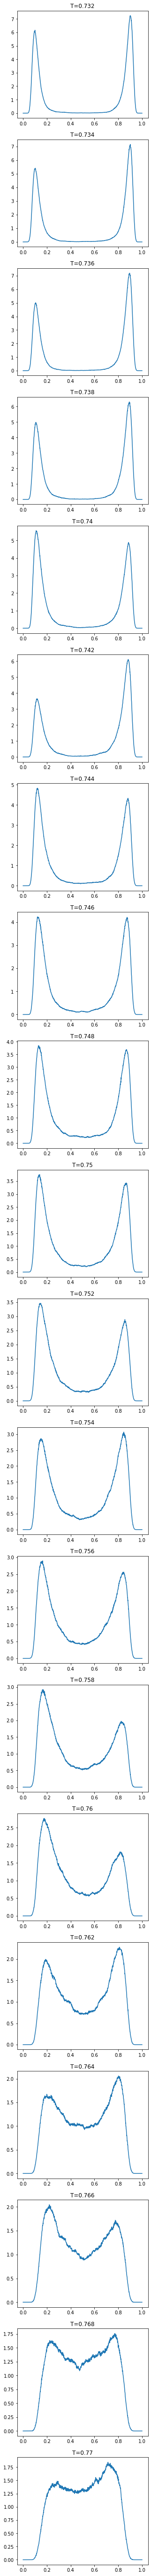

In [15]:
plotMultipleProbDists()

In [ ]:
plotMultipleProbDists()

## Phase diagram and Binder cumulant

In [ ]:
PhaseBinderResults = readFileFromDialog()

In [ ]:
Fig, Ax = plt.subplots(1,1,squeeze=False, figsize=(5,5))
a = Ax[0,0].plot(PhaseBinderResults[:,1],PhaseBinderResults[:,0],'.')
Ax[0,0].plot(1.0-PhaseBinderResults[:,1],PhaseBinderResults[:,0],'.',color=a[0].get_color())
Ax[0,0].set_ylabel('T')
Ax[0,0].set_xlabel('xA')
Ax[0,0].set_title('phase diagram')

In [ ]:
Fig, Ax = plt.subplots(1,1,squeeze=False, figsize=(5,5))
Ax[0,0].plot(PhaseBinderResults[:,0],PhaseBinderResults[:,2],'.')
Ax[0,0].set_xlabel('T')
Ax[0,0].set_ylabel('Binder-cumulant')
Ax[0,0].set_title('Binder-cumulant vs T')
#Ax[0,0].set_xlim(0.58,0.62)
#Ax[0,0].set_ylim(0.3,0.68)

## Binder cumulant and phase diagram multiple N

In [ ]:
NList, PhaseBinderResultsList = readMultiplePhaseBinderResults()

In [ ]:
NPhaseBinderResultsDict = {}
for i in range(len(NList)):
    NPhaseBinderResultsDict[NList[i]] = PhaseBinderResultsList[i]
NPhaseBinderResultsDictSorted = dict(sorted(NPhaseBinderResultsDict.items(),key=lambda x:x[0]))

In [ ]:
Fig, Ax = plt.subplots(1,1,squeeze=False, figsize=(8,8))
for N in NPhaseBinderResultsDictSorted:
    if (N < 16001):
        PhaseBinderResults = NPhaseBinderResultsDictSorted[N]
        Ax[0,0].plot(PhaseBinderResults[:,0],PhaseBinderResults[:,2],'.-',label=str(N))
Ax[0,0].set_ylabel('Binder cumulant')
Ax[0,0].set_xlabel('T')
Ax[0,0].set_title('Binder cumulant vs T, long runs 2+3 combined')
#Ax[0,0].set_xlim(0.7,0.75)
#Ax[0,0].set_ylim(0.6,0.67)
Ax[0,0].legend()
#Fig.savefig("plots/roh=0.75/roh=0.75_binder_cumulant_long_2_3_combined.png",format='png',dpi=200)

In [ ]:
Fig, Ax = plt.subplots(1,1,squeeze=False, figsize=(8,8))
for i in range(len(NList)):
    N = NList[i]
    PhaseBinderResults = PhaseBinderResultsList[i]
    a = Ax[0,0].plot(PhaseBinderResults[:,1],PhaseBinderResults[:,0],'.-',label=str(N))
    Ax[0,0].plot(1.0-PhaseBinderResults[:,1],PhaseBinderResults[:,0],'.-',color=a[0].get_color())
Ax[0,0].set_ylabel('T')
Ax[0,0].set_xlabel(r'$x_A$')
Ax[0,0].set_title('phase diagrams')
Ax[0,0].set_xlim(0.16,0.25)
#Ax[0,0].set_ylim(0.73,0.775)
Ax[0,0].legend()
#Fig.savefig("plots/roh=0.75/roh=0.75_phase_diagram_long_run_eq_index=10^6.png",format='png',dpi=200)

## Plot particle positions

In [ ]:
APositions, BPositions = readParticleConfigFromDialog(0)

In [ ]:
Fig, Host = plt.subplots(1,1,squeeze=False,figsize=(5,5),dpi =200)
Host[0,0].plot(APositions[:,0],APositions[:,1],'.',color='b',ms=2)
Host[0,0].plot(BPositions[:,0],BPositions[:,1],'.',color='darkorange',ms=2)
Host[0,0].set_xlabel('x')
Host[0,0].set_ylabel('y')
Host[0,0].set_xlim(0,1)
Host[0,0].set_ylim(0,1)
#Fig.savefig('ParticleConfig_T=0.52_N=16000_multiple_phases present'+'.png',format='png')

# Automatized data analysis

In [ ]:
Density, Temperatures, NASeries, TotalNumberOfParticles, epsAB = readInResults()

## Phase diagram by moments of distribution

In [ ]:
FirstMoments = computeFirstMoments(NASeries, Temperatures, TotalNumberOfParticles[0])

In [ ]:
Fig, Ax = plt.subplots(1,1,squeeze=False,figsize=(10,5),dpi=200)
Ax[0,0].errorbar(FirstMoments,Temperatures,yerr=None,xerr=None,fmt='.',capsize=5)
Ax[0,0].errorbar(1.0 - np.array(FirstMoments),Temperatures,yerr=None,xerr=None,fmt='.',capsize=5)
Ax[0,0].set_xlim(0,1.0)
#Ax[0,0].set_ylim(0.3,1.1)
Ax[0,0].set_xlabel(r'$x_A$')
Ax[0,0].set_ylabel(r'$T \left[ \frac{\epsilon_{AA}}{k_B} \right]$')
Ax[0,0].set_title(r'phase diagram for $\rho=$'+str(Density)+r', $\epsilon_{AB}=$'+str(epsAB)+r' $\epsilon_{AA}$')
Fig.savefig('phase-diagram_roh='+str(Density)+'_N=1000_eps_AB='+str(epsAB)+'.png',format='png')

## Fits

In [ ]:
def smoothCurve(RawCurve,WindowLength):
    SmoothedArray = np.zeros(len(RawCurve))
    OffsetMax = WindowLength//2
    for i in range(len(RawCurve)):
        Average = 0.0
        NumberOfDataPoints = 0
        for Offset in np.arange(-OffsetMax, OffsetMax, 1):
            if (i+Offset >= 0 and i+Offset < len(RawCurve)):
                Average += RawCurve[i+Offset]
                NumberOfDataPoints += 1
        SmoothedArray[i] = Average/NumberOfDataPoints
    return SmoothedArray

def lumpData(yData,xData,WindowLength):
    LumpedyData = np.zeros(len(yData) // WindowLength)
    LumpedxData = np.zeros(len(yData) // WindowLength)
    i = 0
    Index = 0
    for Index in range(len(LumpedyData)):
        LumpedxData[Index] = xData[i]+WindowLength/2
        NewAverage = 0.0
        NumberOfDataPoints = 0
        for j in range(WindowLength):
            if (i+j < len(yData)):
                NewAverage += yData[i+j]
                NumberOfDataPoints += 1
        LumpedyData[Index] = NewAverage/NumberOfDataPoints
        i += WindowLength
    return LumpedyData, LumpedxData

def computeLocalMaxima(LumpedyData,LumpedxData):
    LocalMaxima = []
    for i in range(len(LumpedData)):
        if (i-1 >= 0 and i+1 < len(LumpedyData)):
            if (LumpedyData[i-1] < LumpedyData[i] and LumpedyData[i+1] < LumpedyData[i]):
                LocalMaxima.append(LumpedxData[i])
    return LocalMaxima

In [ ]:
yValues, xValues = computeHist(NumberOfASeries[NumberIndex:])

In [ ]:
GaussParameters, GaussCovariance = curve_fit(Gaussian,xValues,yValues,p0=[max(yValues),10,30],bounds = ([0,0,0],[1.2*max(yValues),1000,500]),maxfev=1000000)
print('mean='+str(round(GaussParameters[1],3))+'+-'+str(round(GaussParameters[2],3))+' , Max: '+str(round(GaussParameters[0],3)))

In [ ]:
LogNormParameters, LogNormCovariance = curve_fit(LogNorm,xValues,yValues,p0=[max(yValues),5,1],maxfev=1000000)
print('a='+str(round(LogNormParameters[0],1))+'| mu = '+str(round(LogNormParameters[1],2))+' | sigma = '+str(round(LogNormParameters[2],3)))
print('mode = '+str(round(np.exp(LogNormParameters[1]-LogNormParameters[2]**2),2)))

In [ ]:
def computeUncertaintyPositionsOfLogNormFit(xValues,LogNormParameters,RatioOfMax):
    Positions = np.zeros(2)
    Mode = np.exp(LogNormParameters[1]-LogNormParameters[2]**2)
    Max = LogNorm(Mode,*LogNormParameters)
    LeftPos = int(Mode)
    while (LogNorm(LeftPos,*LogNormParameters) > Max*RatioOfMax and LeftPos > xValues[0]):
        LeftPos -= 1
    Positions[0] = LeftPos
    RightPos = int(Mode)
    while (LogNorm(RightPos,*LogNormParameters) > Max*RatioOfMax and RightPos < xValues[-1]):
        RightPos += 1
    Positions[1] = RightPos
    return Positions

In [ ]:
LogNormUncertaintyPositions = computeUncertaintyPositionsOfLogNormFit(xValues,LogNormParameters, 0.1)
print(LogNormUncertaintyPositions)

In [ ]:
Fig, Ax = plt.subplots(1,1,squeeze=False,figsize=(5,5))
Ax[0,0].plot(xValues, yValues,'.')
Ax[0,0].plot(xValues,Gaussian(xValues,*GaussParameters))
Ax[0,0].plot(xValues,LogNorm(xValues,*LogNormParameters))
Ax[0,0].vlines(LogNormUncertaintyPositions[0],np.min(yValues),np.max(yValues),color = 'k', alpha = 0.5)
if (LogNormUncertaintyPositions[1] < np.max(xValues)):
    Ax[0,0].vlines(LogNormUncertaintyPositions[1],np.min(yValues),np.max(yValues),color = 'k', alpha = 0.5)

## Phase diagram by fitting

In [ ]:
def computeResultsByFittingLogNorm(Temperatures, NASeries, TotalNumberOfParticles):
    FractionsOfA = np.zeros(len(Temperatures))
    Deviations = np.zeros((2,len(Temperatures)))
    for i in range(len(Temperatures)):
        NumberOfAAverage, AverageNumberDeviation, NumberIndex = computeEquilibriumAverage(NASeries[i])
        yValues, xValues = computeHist(NASeries[i])
        LogNormParameters, LogNormCovariance = curve_fit(LogNorm,xValues,yValues,p0=[max(yValues),5,1],maxfev=1000000)
        LogNormUncertaintyPositions = computeUncertaintyPositionsOfLogNormFit(xValues,LogNormParameters, 0.1)
        Mode = np.exp(LogNormParameters[1]-LogNormParameters[2]**2)
        print('T=',Temperatures[i],':')
        print('a='+str(round(LogNormParameters[0],1))+'| mu = '+str(round(LogNormParameters[1],2))+' | sigma = '+str(round(LogNormParameters[2],3)))
        print('mode = '+str(round(Mode,2))+" , uncertainty positions: "+str(LogNormUncertaintyPositions))
        FractionsOfA[i] = Mode/TotalNumberOfParticles[i]
        Deviations[0,i] = (Mode - LogNormUncertaintyPositions[0])/TotalNumberOfParticles[i]
        Deviations[1,i] = (LogNormUncertaintyPositions[1] - Mode)/TotalNumberOfParticles[i]
    return Temperatures, FractionsOfA, Deviations

In [ ]:
Temperatures, FractionsOfA, Deviations = computeResultsByFittingLogNorm()

In [ ]:
Fig, Host = plt.subplots(1,1,squeeze=False,figsize=(10,5))
Host[0,0].errorbar(FractionsOfA,Temperatures,yerr=None,xerr=Deviations,fmt='.',capsize=5)
Host[0,0].set_xlim(0,0.7)
Host[0,0].set_ylim(0.55,0.71)

## Phase diagram as colorplot

In [ ]:
def prepareDataForColorplot(Temperatures, NASeries, TotalNumberOfParticles):
    Temperatures, NASeries, TotalNumberOfParticles
    C = np.zeros((len(Temperatures),int(TotalNumberOfParticles[0]+1)))
    xCenters = np.linspace(0,TotalNumberOfParticles[0],num = int(TotalNumberOfParticles[0]+1))/TotalNumberOfParticles[0]
    yCenters = np.array(Temperatures)
    for i in range(len(Temperatures)):
        NumberOfAAverage, AverageNumberDeviation, NumberIndex = computeEquilibriumAverage(NASeries[i])
        yValues, xValues = computeHist(NASeries[i][NumberIndex:])
        C[i,xValues[0]:xValues[-1]+1] = yValues
        C[i,int(TotalNumberOfParticles[0])-(xValues[-1]+1):int(TotalNumberOfParticles[0])-xValues[0]] = yValues[::-1]
    return xCenters,yCenters,C

In [ ]:
xCenters,yCenters,C = readInResultsForColorplot()

In [ ]:
Fig, Ax = plt.subplots(2,1,squeeze=False,figsize=(12,12))
AllDataPlot = Ax[0,0].pcolormesh(xGrid,yGrid,C,shading='nearest',cmap='hot',norm=PowerNorm(1.0))
Fig.colorbar(AllDataPlot, ax = Ax[0,0])
ZoomedInPlot = Ax[1,0].pcolormesh(xCenters[100:-100],yCenters[6:-16],C[6:-16,100:-100],shading='nearest',cmap='hot',norm= PowerNorm(1.0))
Fig.colorbar(ZoomedInPlot,ax = Ax[1,0])
for i in range(2):
    Ax[i,0].set_xlabel('$x_A$')
    Ax[i,0].set_ylabel(r'T $\left[\frac{\epsilon_{AA}}{k_{B}}\right]$')
Fig.savefig('phase-diagram_roh=0.8_N=2000.png',format='png')

## Plot of used potential

In [ ]:
rCut = 2.5
NumberOfPoints = 500
rValues = np.linspace(0.6,3.0,num=NumberOfPoints)
def Potential(r,eps):
    return 4.0*eps*(r**(-12) - r**(-6) - rCut**(-12) + rCut**(-6) - (r-rCut)*(-12.0*rCut**(-13)+6.0*rCut**(-7)))
PotValues1 = np.zeros(NumberOfPoints)
PotValues2 = np.zeros(NumberOfPoints)
for i in range(NumberOfPoints):
    PotValues1[i] = Potential(rValues[i],1.0)
    PotValues2[i] = Potential(rValues[i],0.1)

In [ ]:
Fig, Ax = plt.subplots(1,1,squeeze=False)
Ax[0,0].plot(rValues,PotValues1)
Ax[0,0].plot(rValues,PotValues2)
Ax[0,0].set_ylim(-1,1.2)